In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '../data/datafix.csv'

concat_select = pd.read_csv(datafix)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `XGBoost`를 이용하도록 하겠습니다.

In [3]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1029552, 48) (9272, 48)


In [4]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
1029552,개포6차우성,79.97,26,5,1987,언주로 3,아파트,분양,자치관리,계단식,...,1,중형,-0.806003,1,2,2,8학군,0.80757,3.5,0


In [5]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

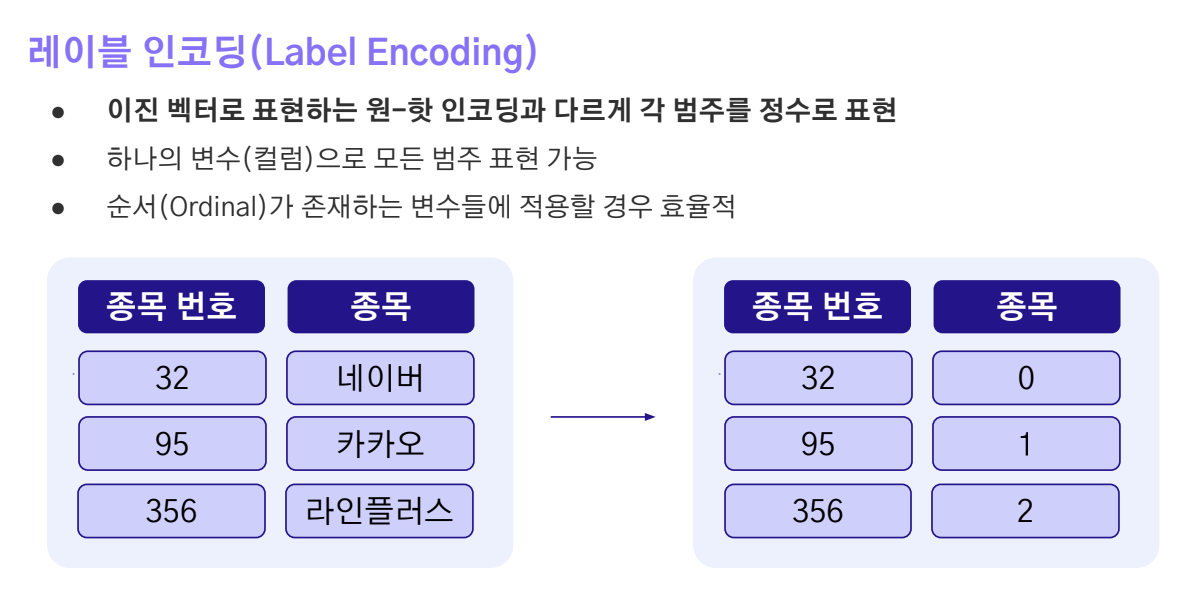

In [6]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '계약년', '계약월', '강남여부', '가격상승률', '동등급', '브랜드등급', '한강근접여부', '지하철거리', '기준금리', '신축여부']
범주형 변수: ['아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '관리비 업로드', '단지신청일', '구', '동', '평형대', '학군']


In [7]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                      0
전용면적                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
관리비 업로드                   0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                    0
is_test                   0
구                   

In [9]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 21/21 [00:05<00:00,  3.61it/s]


In [10]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
0,293,79.97,8,3,1987,5520,3,2,2,1,...,1,2,1.185023,1,2,2,9,0.80757,1.5,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [11]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [12]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [13]:
import xgboost

model=xgboost.XGBRegressor(
    device='gpu'
)

### 하이퍼파라미터 탐색을 위한 코드

- GridSearch와 RandomSearch 중 선택을 고민했습니다
- GridSearch는 모든 경우의 수를 따져서 시간이 많이 소요되므로 RandomSearch 를 선택했습니다.
- 최적의 하이퍼파라미터를 이미 찾아 아래 코드에서 사용하고있으니 앞으로 실행할 필요는 없습니다.

In [14]:

# base_score=[0.25,0.5,0.7]

# n_estimators = [500, 1000, 1500, 2000]
# max_depth = [3, 5, 7, 10]
# booster=['gbtree']
# learning_rate=[0.01, 0.03, 0.05, 0.1]
# min_child_weight=[1, 5, 10]

# hyperparameter_grid = {
#     'n_estimators': n_estimators,
#     'max_depth':max_depth,
#     'learning_rate':learning_rate,
#     'min_child_weight':min_child_weight,
#     'booster':booster,
#     'base_score':base_score
#     }

# random_cv = RandomizedSearchCV(estimator=model,
#             param_distributions=hyperparameter_grid,
#             cv=5, n_iter=50,
#             scoring = 'neg_mean_absolute_error',n_jobs = -1,
#             verbose = 5, 
#             return_train_score = True,
#             random_state=42)


In [15]:
# random_cv.fit(X_train, y_train)

In [16]:
# random_cv.best_params_

In [17]:
# random_cv.best_score_

### 하이퍼파라미터 선택지들

* 현재까지 파악된 제일 좋은 점수를 보이는 하이퍼파라미터는 learningRate=0.05, n_estimator=5000 입니다.
* 하지만 n_estimator변수의 값이 높으면 과적합 우려가 있습니다.
* 추후 EDA가 완료된 후 n_estimator값이 낮은 모델로도 학습 후 테스트가 필요합니다.

각 하이퍼파라미터별로 상단에 점수를 기재해두었습니다.


In [18]:
#44490
# n_estimators가 작다
# EDA가 완료된 후 아래 파라미터로도 학습 후 테스트가 필요요
# model=xgboost.XGBRegressor(
#  n_estimators= 900,
#  learning_rate= 0.15,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.25)
 
# 45045.5677
# model=xgboost.XGBRegressor(
#  n_estimators= 1500,
#  learning_rate= 0.1,
#  max_depth= 10,
#  min_child_weight= 1,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43815.4360
# RMSE test: 4280.667057047746
# model=xgboost.XGBRegressor(
#  n_estimators= 2000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

# 43752.7333
# RMSE test: 4226.164120555658
# model=xgboost.XGBRegressor(
#  n_estimators= 3000,
#  learning_rate= 0.05,
#  max_depth= 10,
#  min_child_weight= 5,
#  booster= 'gbtree',
#  device='cuda',
#  base_score= 0.5)

In [19]:
# 현재까지 제일 성능이 좋은 하이퍼파라미터 입니다.
# n_estimators가 꽤 큰값이라 과적합 우려가 있습니다다.
# EDA가 끝나고 n_estimator가 작은 하이퍼파라미터로 학습을 시키고 점수를 비교해봐야 합니다.
# 43735.7052
# RMSE test: 4206.333504214999
model=xgboost.XGBRegressor(
 n_estimators= 500,
 learning_rate= 0.05,
 max_depth= 10,
 min_child_weight= 5,
 booster= 'gbtree',
 device='cuda',
 base_score= 0.5)

In [20]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
pred = model.predict(X_val)

~~- 포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다~~

In [22]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

# n_estimators = 4000 : 1153.927997440971
# n_estimators = 3000 : 1152...
# n_estimators = 2000 : 1150.6300030243262
# n_estimators = 1000 : 1145.027811961602
# n_estimators = 500 : 1139.9269446802118       <<<<
    # learning_rate= 0.1 : 1143.8468634812389
    # learning_rate= 0.06 : 1139.4134303625754  <<<<
    # learning_rate= 0.05 : 1139.9269446802118
    # learning_rate= 0.01 : 1257.2375186511936
# n_estimators = 250 : 1144.567357701914


RMSE test: 1077.45065834594


- 변수 중요도도 확인해보도록 하겠습니다.

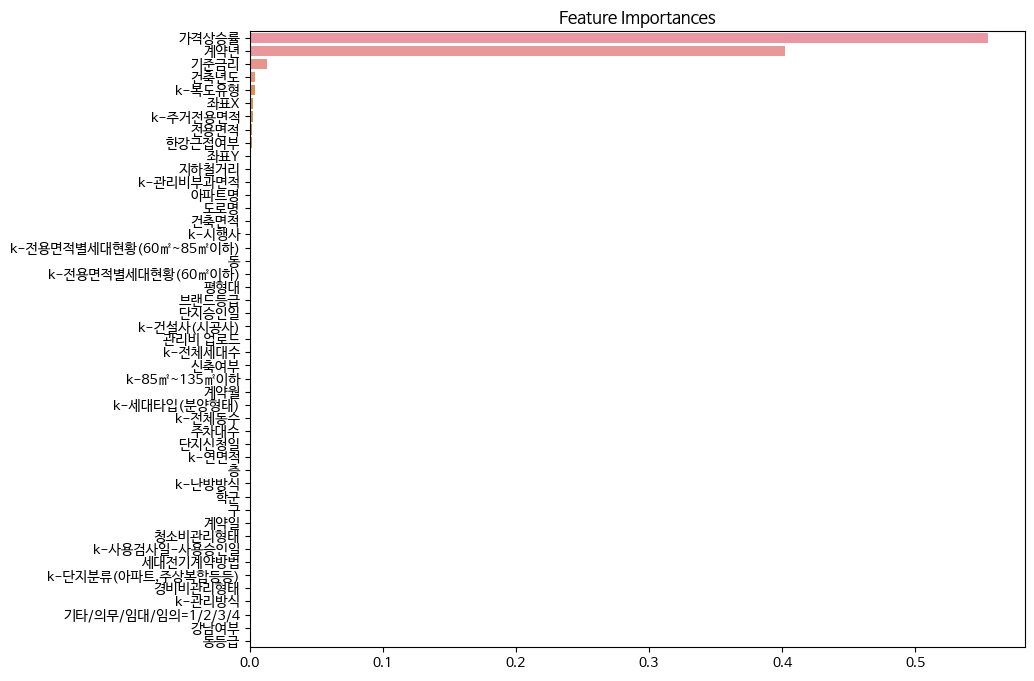

In [23]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [24]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [25]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=len(X_val.columns))    # valid data에 대해 적합시킵니다.

Weight,Feature
1876375063.0476 ± 12152213.8665,가격상승률
739182486.0241 ± 8096780.4837,계약년
3204163.3106 ± 383488.5471,전용면적
1818300.8628 ± 104430.4167,기준금리
1038738.8758 ± 114088.6770,건축년도
497083.4196 ± 56114.8134,좌표X
255308.4641 ± 16051.5397,계약월
205004.0405 ± 43127.7036,도로명
161844.3158 ± 12686.0444,지하철거리
139268.5355 ± 113935.4752,좌표Y


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [26]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [27]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [28]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [29]:
X_val_sort.head()

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
197282,575,117.11,17,3,1984,3934,0,0,0,0,...,1,2,1,9,0.554552,3.50,0,243000.0,347845.12500,1.099250e+10
197285,1557,84.95,1,26,2023,0,0,0,0,0,...,1,1,1,9,0.556594,3.50,1,360000.0,278270.68750,6.679681e+09
2740,5372,121.32,4,12,1977,5233,0,0,0,0,...,1,2,2,9,0.738040,1.50,0,245000.0,322115.53125,5.946805e+09
197723,2773,108.93,17,27,2018,609,3,1,1,5,...,1,1,2,0,0.588393,3.50,1,239000.0,313867.40625,5.605129e+09
400140,300,61.57,18,3,1982,4426,3,2,2,1,...,1,2,2,9,0.803183,1.25,0,260000.0,188708.06250,5.082540e+09


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [30]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [31]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [32]:
display(error_top100.head(5))
display(best_top100.head(1))

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
197282,궁전,117.11,17,3,1984,사평대로 142,nan,nan,nan,nan,...,1,2,1,8학군,0.554552,3.50,0,243000.0,347845.12500,1.099250e+10
197285,래미안원베일리,84.95,1,26,2023,,nan,nan,nan,nan,...,1,1,1,8학군,0.556594,3.50,1,360000.0,278270.68750,6.679681e+09
2740,한양1차,121.32,4,12,1977,압구정로 321,nan,nan,nan,nan,...,1,2,2,8학군,0.738040,1.50,0,245000.0,322115.53125,5.946805e+09
197723,서울숲리버뷰자이,108.93,17,27,2018,고산자로2길 65,아파트,기타,위탁관리,혼합식,...,1,1,2,10학군,0.588393,3.50,1,239000.0,313867.40625,5.605129e+09
400140,개포주공1단지,61.57,18,3,1982,선릉로 7,아파트,분양,자치관리,계단식,...,1,2,2,8학군,0.803183,1.25,0,260000.0,188708.06250,5.082540e+09


,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부,target,pred,error
673172,송파파인타운12단지,84.9,16,8,2011,송파대로8길 42,nan,nan,nan,nan,...,1,2,2,6학군,0.425319,2.0,0,62800.0,62800.035156,0.001236


- 이제 분포를 비교해보도록 하겠습니다.

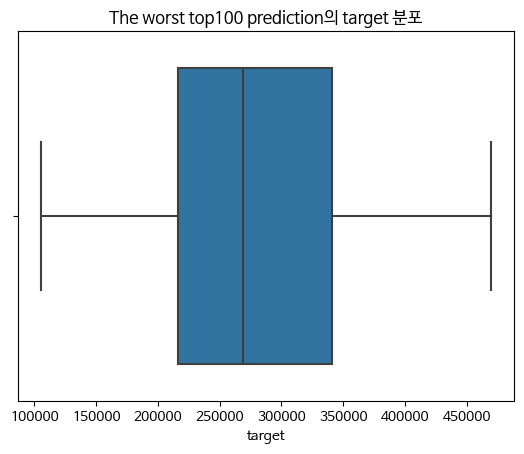

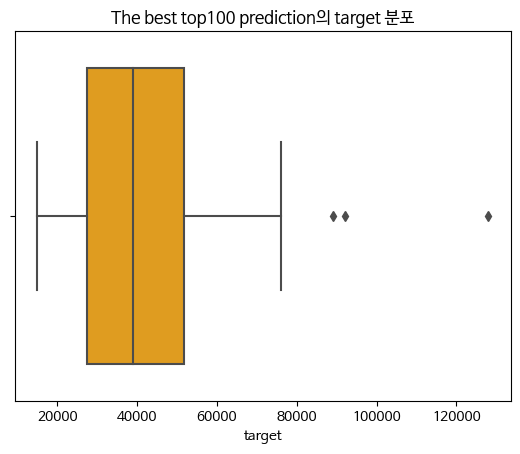

In [33]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

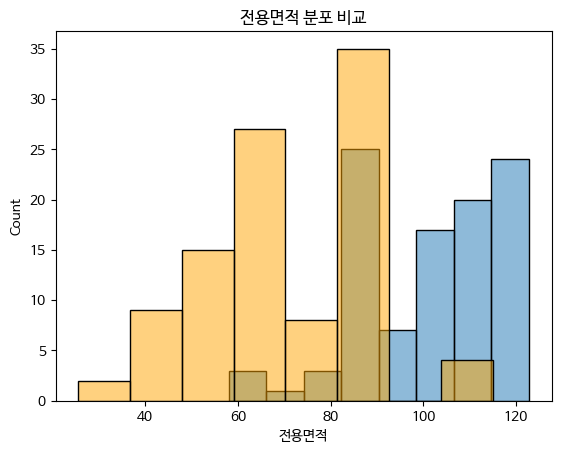

In [34]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [35]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,...,강남여부,평형대,가격상승률,동등급,브랜드등급,한강근접여부,학군,지하철거리,기준금리,신축여부
1029552,293,79.9700,26,5,1987,5520,3,2,2,1,...,1,2,-0.806003,1,2,2,9,0.807570,3.5,0
1029553,294,108.2017,15,10,2021,431,3,2,1,1,...,1,0,-0.806003,1,1,2,9,0.787231,3.5,1


In [36]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [37]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 119 ms, sys: 4.45 ms, total: 124 ms
Wall time: 27.9 ms


In [38]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([18227.459, 17667.35 , 19112.037, ..., 17174.234, 17185.588,
       17162.922], dtype=float32)

## 7. Output File Save

In [39]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)